# answers 10: the cycle of twelve


In [1]:
import numpy as np
import re
import scipy.stats       as stats
import scipy.optimize    as optimize
import matplotlib.pyplot as plt

%matplotlib inline

datafile = 'w10-data.tbl'

### Read in the data. 

This parsing code is taking from [moriarty.py](moriarty.py), and slightly modified, adding a `reliability[]` flag that I'll use to color points in my plots at the end.

In [2]:
# Parse the data file.
# This leaves us with
#    N              : number of experiments (columns in the table)
#    G              : number of genes (rows in the table)
#    genenames[i]   : names of the genes
#    X[i]           : array of time points, in hrs, for the N experiments
#    S_true[i]      : array of sigmas for the experiments
#    Y[i][t]        : GxN: observed tpm for gene i, time point t
#    reliability[i] : 'H', 'M', 'L' for sigma = 2, 5, 20
#   
with open(datafile) as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    X = np.array(X)
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    reliability = []
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        if   match.group(1) == '2': reliability.append('H')
        elif match.group(1) == '5': reliability.append('M')
        else:                       reliability.append('L')
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)


### Moriarty's solution

Moriarty solved with least squares. Each solution gives us three variables per gene: baseline $b$, amplitude $a$, and phase $\phi$ that we'll call `p` in our python variables. We'll call the least squares solutions `a_fit`, etc.

You may have noticed that there's a degenerate solution: for every solution with positive amplitude $a$ and phase $\phi$, there's an equivalent solution with negative amplitude $-a$ and phase $\phi + 12$hr. Here, and in the ML solution below, I check for that and flip a $-a,\phi$ solution to $+a, \phi +12$.

In [3]:
b_fit = np.zeros(G)   # least squares baseline fit, for each gene
a_fit = np.zeros(G)   # amplitude fit, for each gene
p_fit = np.zeros(G)   # phase \phi fit, for each gene

for g in range(G):
     # This solves for baseline, amplitude, phase by least squares fitting:
    #    y_t = b + (a cos p) sin t + (a sin p) cos t
    # 
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * np.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * np.pi * X[i] / 24)

    try:
        result    = np.linalg.lstsq(A, Y[g], rcond=-1)[0]    # numpy's ordinary least squares fitter
    except:
        sys.exit("Linear least square fit failed")

    p_fit[g]  = np.arctan(result[2] / result[1])   # phase in radians
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])

    p_fit[g] = 24 * p_fit[g] / (2 * np.pi)       # convert phase to hours
    if a_fit[g] < 0:                               # there's a degeneracy in the solution: negative amplitude & phase offset by 12hr
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24


## 1. solve by maximum likelihood

Now the maximum likelihood solutions, which we'll call `a_opt`, etc.

To solve, we'll just define a negative log likelihood function `nll()`, in the format that the SciPy optimizer needs, and hand it to the SciPy optimizer. This isn't the most efficient way of solving it (in terms of computation time)! But it works fine, and it's pretty efficient in terms of _our_ time.

In [4]:
def to_radians(h):
    return (h * 2 * np.pi / 24)

# nll():
# negative log likelihood objective function, compatible
# with the interface to scipy's `optimize`.
#   v = current parameter values (b,a,p)
#   X = time points, hrs
#   Y = TPM measurements
#   s = std dev for each data point
#
def nll(v, X, Y, s):
    b     = v[0]
    a     = v[1]
    p     = v[2]
    LL    = 0.
    for i,t in enumerate(X):
        yhat     = b +  a * np.sin( to_radians(t + p))
        residual = Y[i] - yhat
        LL      += stats.norm.logpdf(residual, loc=0, scale=s[i])
    return -LL

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

for g in range(G):
    guess     = np.array([10., 10., 10.])                         # any initial guess will do.
    result    = optimize.minimize(nll, guess, (X, Y[g], S_true))  # hand our objective function to the SciPy minimizer
    if result.success != True:
        sys.exit("Maximum likelihood fit failed")

    b_opt[g] = result.x[0]
    a_opt[g] = result.x[1]
    p_opt[g] = result.x[2]

    if a_opt[g] < 0:                       # Rectify a degenerate solution w/ a negative amplitude and a 12-hr offset in phase
        a_opt[g] = -a_opt[g]
        p_opt[g] += 12
    while p_opt[g] < 0:  p_opt[g] += 24
    while p_opt[g] > 24: p_opt[g] -= 24


## 2. compare solutions

We're asked to calculate the total log likelihood of the two solutions. Let's also print a table of the results.

In [5]:
# we're going to sort genes according to their maximum likelihood phase.
# a concise trick for that: create a sorted list of indices 0..G-1
# Sort from high to low on phase, so genes come out in order that their 
# expression rises.
#
ranked_at = sorted(list(range(G)), key=lambda g: p_opt[g], reverse=True)

# we're asked to calculate the total log likelihood of Moriarty's solution,
# versus our maximum likelihood solution
ll_opt = 0
ll_fit = 0
for g in range(G):
    ll_opt -= nll( [b_opt[g], a_opt[g], p_opt[g]], X, Y[g], S_true)
    ll_fit -= nll( [b_fit[g], a_fit[g], p_fit[g]], X, Y[g], S_true)

print("{0:12s} {1:>20s} {2:>20s}".format('', 'least squares', 'maximum likelihood'))
print("{0:12s} {1:20s} {2:20s}".format('', '-'*20, '-'*20))
print("{0:12s} {1:>6s} {2:>6s} {3:>6s} {4:>6s} {5:>6s} {6:>6s}".format('genename', 'b', 'a', 'p', 'b', 'a', 'p'))
print("{0:12s} {1:6s} {2:6s} {3:6s} {4:6s} {5:6s} {6:6s}".format('-'*12, '-'*6,'-'*6,'-'*6,'-'*6,'-'*6,'-'*6))
for k in range(G):
    g = ranked_at[k]
    print("{0:12s} {1:6.1f} {2:6.1f} {3:6.1f} {4:6.1f} {5:6.1f} {6:6.1f}".format(genenames[g], b_fit[g], a_fit[g], p_fit[g], b_opt[g], a_opt[g], p_opt[g]))

print('')
print("total log likelihood of Moriarty's solution:         {0:.1f}".format(ll_fit))
print("total log likelihood of maximum likelihood solution: {0:.1f}".format(ll_opt))

                    least squares   maximum likelihood
             -------------------- --------------------
genename          b      a      p      b      a      p
------------ ------ ------ ------ ------ ------ ------
slwZ           40.6   26.1    0.3   45.4   26.5   22.4
wkiN           45.6   17.0   19.5   47.6   19.0   19.8
wjmU           55.6   33.2   18.7   49.1   29.9   18.0
wicQ           31.6    6.8   14.5   37.6   20.9   16.6
uhxN           46.3   15.1   15.6   46.4   23.2   14.1
zgvC           45.9   29.7   12.4   45.0   25.1   12.1
lfpY           38.3   19.2    9.6   40.9   22.9    9.6
retS           48.2   17.2    7.8   49.0   25.2    8.2
vdbK           42.3   12.7    5.7   45.4   17.5    6.2
dczC           49.6   30.4    5.1   49.4   27.3    3.9
cbaJ           36.3   26.3    0.1   47.5   21.9    1.9
jarO           44.0   35.2   22.4   43.7   22.9    0.1

total log likelihood of Moriarty's solution:         -519.4
total log likelihood of maximum likelihood solution: -311.8

**summary**: Moriarty has a different order for slwZ vs. jarO, and for wicQ vs. uhxN. Also, the maximum likelihood solution has phases that are regularly spaced, about 2 hrs apart. Moriarty's harmonic regression does not give this nice regular spacing.

We'd happily take pretty much any bet Moriarty wants to offer us; the odds are massively in favor of the ML solution.

It turns out that the ML solution is the correct order. The true phases $\phi$ are evenly distributed, just 2, 4, ... 24 hr for the 12 genes, as you might have guessed.  

## 3. plot the fits

First some bonus plotting: scatter plots of the least squares fits versus the ML estimates, for all 12 genes.

Text(0.5, 1.0, 'phase $\\phi$')

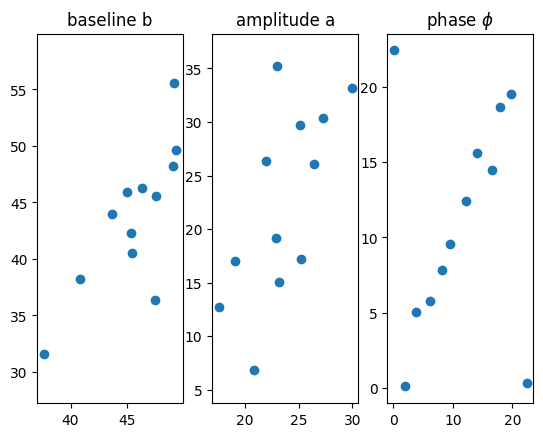

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(b_opt, b_fit)
ax1.axis('equal')
ax1.set_title('baseline b')
ax2.scatter(a_opt, a_fit)
ax2.axis('equal')
ax2.set_title('amplitude a')
ax3.scatter(p_opt, p_fit)
ax3.set_title(r'phase $\phi$')

We haven't been paying a lot of attention to the baseline and amplitude, but we can see there's a lot of difference between us and Moriarty there too.

Now let's look at plots of the data versus the two fits, for each gene, ordered by the ML phases. Our ML estimate will be a thick green line. Moriarty's fit is a thin grey line.

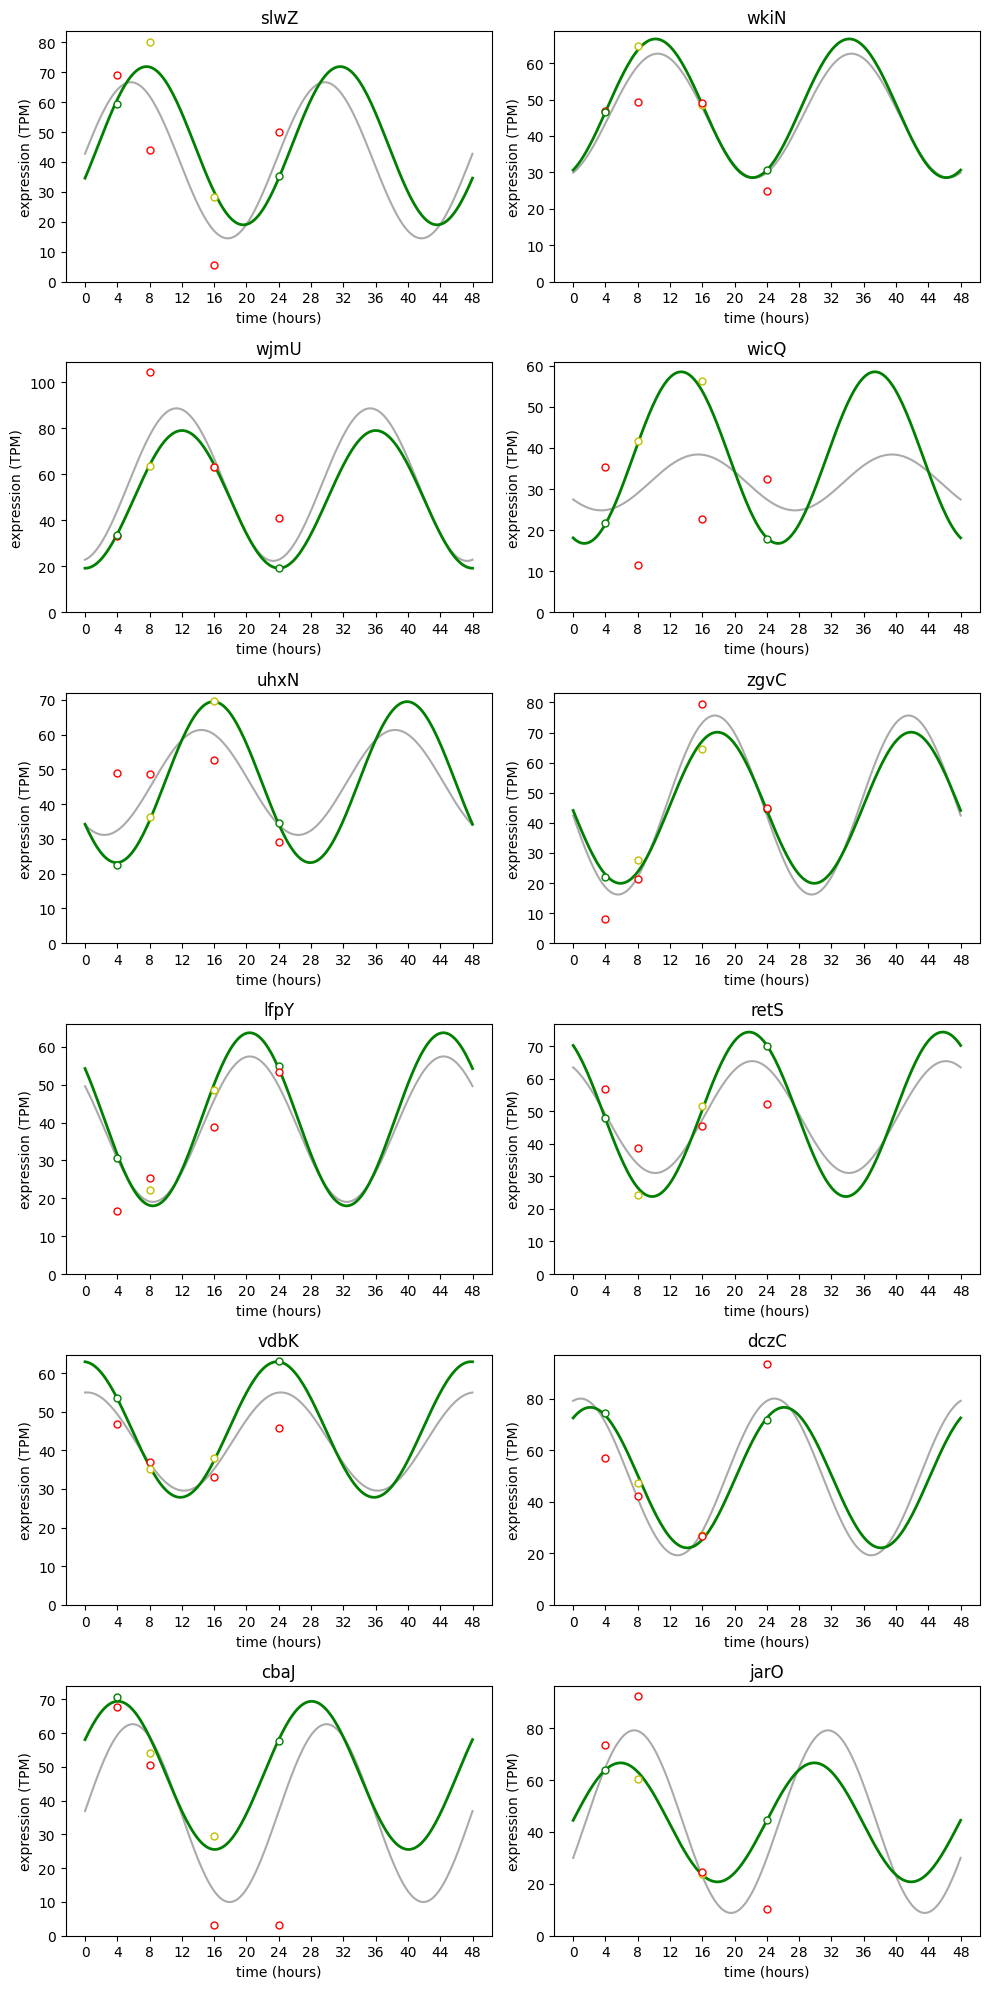

In [7]:
def make_plot_line(xpoints, b, a, p):
    N = len(xpoints)
    Y = np.zeros(N)
    for i,x in enumerate(xpoints):
        Y[i] = b + a * np.sin( to_radians(x + p) ) 
    return Y

f, axarr = plt.subplots(6, 2, figsize=(10,20))
xpoints  = np.linspace(0., 48., 200)
for k in range(G):
    g = ranked_at[k]    # plots are sorted by their maximum likelihood phase
    row = k // 2
    col = k % 2
    axarr[row,col].plot(xpoints, make_plot_line(xpoints, b_fit[g], a_fit[g], p_fit[g]), color='#aaaaaa')
    axarr[row,col].plot(xpoints, make_plot_line(xpoints, b_opt[g], a_opt[g], p_opt[g]), color='g', linewidth=2)
    for i in range(N):
        if reliability[i] == 'L':
            axarr[row,col].plot(X[i], Y[g][i], 'ro', markersize=5, mfc='w', markeredgewidth=1)
        elif reliability[i] == 'M':
            axarr[row,col].plot(X[i], Y[g][i], 'yo', markersize=5, mfc='w', markeredgewidth=1)
        else:
            axarr[row,col].plot(X[i], Y[g][i], 'go', markersize=5, mfc='w', markeredgewidth=1)
            
    axarr[row,col].set_xticks( list(range(0,49,4)) )
    axarr[row,col].set_ylim(ymin=0)
    axarr[row,col].set_title(genenames[g])
    axarr[row,col].set_xlabel('time (hours)')
    axarr[row,col].set_ylabel('expression (TPM)')

plt.tight_layout()

**summary**: The main thing to notice here is that the ML estimates are tending to track the reliable data points (green, yellow) and discount the less reliable points (red), because the ML estimation is explicitly using the given error $\sigma_i$ for each point. Ordinary least squares fitting, by implicitly assuming that each residual is drawn from the same distribution, is distracted by the unreliable red points. The ML estimate is equivalent here to what's called _weighted least squares_.

## closing formalities

In [8]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

jupyter   : 1.0.0
numpy     : 2.1.0
matplotlib: 3.9.2

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

